# SemEval 2025 Task 9: The Food Hazard Detection Challenge


## Περιγραφή λύσης

Η λύση αφορά την εκπαίδευση ενός **RoBERTa-large μοντέλου ταξινόμησης κειμένου** για διαφορετικές κατηγορίες (`product-category`, `hazard-category`, `hazard`, `product`).  

### Βασικά βήματα:
1. **Φόρτωση και επεξεργασία δεδομένων**  
   - Χρήση `pandas` για ανάγνωση δεδομένων από CSV.  
   - **Tokenization** των πεδίων `title` και `text` με `RobertaTokenizer`.  
   - **Label Encoding** των κατηγοριών.

2. **Αντιμετώπιση ανισορροπίας δεδομένων**  
   - Εφαρμογή **Data Augmentation** για τις σπάνιες κλάσεις (`product-category`, `hazard`).  
   - Χρήση **Focal Loss** για ανισόρροπα δεδομένα (`hazard`, `product`).  

3. **Εκπαίδευση και αξιολόγηση του μοντέλου**  
   - Χρήση `AdamW` optimizer και `linear scheduler`.  
   - Εκπαίδευση με **Standard Cross-Entropy Loss** (`product-category`, `hazard-category`) ή **Focal Loss** (`hazard`, `product`).  
   - Παρακολούθηση της απόδοσης με **plots για loss & accuracy**.  
   - Δημιουργία **classification report** με `sklearn.metrics`.

Η λύση προσαρμόζεται ανάλογα με τα labels του dataset, βελτιστοποιώντας την απόδοση μέσω **augmentation** και **Focal Loss**, ενώ η χρήση **RoBERTa** εξασφαλίζει υψηλή ακρίβεια στην κατανόηση κειμένου.

## Αποτελέσματα 

- ### SUB-TASK 1 : 0.79  
- ### SUB-TASK 2 : 0.42 



Εγκατάσταση απαραίτητων βιβλιοθηκών για NLP και Machine Learning


In [ ]:
!pip install torch transformers datasets pandas scikit-learn sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 32.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 44.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 36.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 52.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 65.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 58.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 62.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 125.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    DataCollatorWithPadding,
    AdamW,
    get_scheduler
)
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from torch.cuda.amp import autocast, GradScaler

# SUB-TASK 1

Φόρτωση βιβλιοθηκών και ορισμός βοηθητικών συναρτήσεων

- `load_data()`: Φορτώνει και συνδυάζει τα δεδομένα από αρχεία CSV 
(το data χρησιμοποιείται για να ανιχνέυση αν υπάρχουν label στο test που δεν υπάρχουν στο train δεν προσφερει κάτι στα μοντέλα ).
- `tokenize_title_and_text()`: Εφαρμόζει tokenization σε τίτλους και κείμενα.



In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    DataCollatorWithPadding,
    AdamW,
    get_scheduler
)
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from torch.cuda.amp import autocast, GradScaler

# ---------------------------
# Βοηθητικές Συναρτήσεις
# ---------------------------
def load_data(train_file: str, test_file: str):
    """
    Φορτώνει τα δεδομένα από τα αρχεία CSV και τα ενώνει.
    Επιστρέφει: train_df (train+valid), dev_df (test) και το πλήρες DataFrame (για label encoding).
    """
    train = pd.read_csv(train_file, index_col=0)
    test = pd.read_csv(test_file, index_col=0)
    # Συνδυασμός όλων των δεδομένων (για τον label encoder)
    data = pd.concat([train, test]).drop_duplicates().reset_index(drop=True)
    
    return train, test, data

def tokenize_title_and_text(examples, tokenizer, max_length=256):
    """
    Συνδυάζει το 'title' και το 'text' για κάθε δείγμα και εφαρμόζει tokenization.
    
    Args:
        examples: Dictionary με λίστες για τα πεδία 'title' και 'text'.
        tokenizer: Ο tokenizer (π.χ., RobertaTokenizer).
        max_length: Μέγιστος αριθμός tokens.
    
    Returns:
        Το tokenized αποτέλεσμα για τα συνδυασμένα inputs.
    """
    # Συνδυασμός των πεδίων 'title' και 'text'
    combined_inputs = [f"{title} {text}" for title, text in zip(examples["title"], examples["text"])]
    return tokenizer(combined_inputs, padding=True, truncation=True, max_length=max_length)

Εκπαίδευση και αξιολόγηση του μοντέλου

- `train_and_evaluate_model_with_plot()`: Εκπαιδεύει το μοντέλο, αξιολογεί την απόδοσή του και εμφανίζει plots για loss και accuracy.




In [ ]:
import matplotlib as plt
def train_and_evaluate_model_with_plot(model, train_dataloader, dev_dataloader, num_epochs=3, lr=2e-5, device='cuda'):
    """
    Εκτελεί το training του μοντέλου με FP16 Mixed Precision και, 
    μετά από κάθε epoch, αξιολογεί το μοντέλο στον validation set.
    
    Στο τέλος εμφανίζει plot με:
      - Training Loss vs. Validation Loss
      - Validation Accuracy
      
    Returns:
        model: Το εκπαιδευμένο μοντέλο.
        train_losses: Λίστα με το training loss ανά epoch.
        dev_losses: Λίστα με το validation loss ανά epoch.
        dev_accuracies: Λίστα με την validation ακρίβεια ανά epoch.
    """
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = num_epochs * len(train_dataloader)
    warmup_steps = int(0.1 * num_training_steps)
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, 
                                 num_warmup_steps=warmup_steps, 
                                 num_training_steps=num_training_steps)
    
    scaler = GradScaler()  # Για FP16 Mixed Precision
    progress_bar = tqdm(range(num_training_steps))
    
    # Λίστες για καταγραφή των metrics
    train_losses = []
    dev_losses = []
    dev_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        steps = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['labels']
                )
                loss = outputs.loss
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()
            
            epoch_train_loss += loss.item()
            steps += 1
            progress_bar.update(1)
        
        avg_train_loss = epoch_train_loss / steps
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}")
        
        # Αξιολόγηση στο validation set
        dev_loss, dev_accuracy = evaluate_model(model, dev_dataloader, device)
        dev_losses.append(dev_loss)
        dev_accuracies.append(dev_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {dev_loss:.4f} - Accuracy: {dev_accuracy:.4f}")
    
    # Plot των metrics για να εντοπιστεί πιθανό overfitting
    epochs = range(1, num_epochs+1)
    plt.figure(figsize=(12,5))
    
    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, dev_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, dev_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model

Αξιολόγηση του μοντέλου

- `evaluate_model()`: Υπολογίζει το μέσο validation loss και την ακρίβεια του μοντέλου

In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device):
    """
    Εκτελεί αξιολόγηση του μοντέλου στον validation set, υπολογίζοντας
    μέσο loss και ακρίβεια.
    
    Returns:
        avg_loss: Μέσο validation loss.
        accuracy: Συνολική ακρίβεια.
    """
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    steps = 0
    
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            
            predictions = torch.argmax(outputs.logits, dim=-1)
            total_correct += (predictions == batch["labels"]).sum().item()
            total_samples += batch["labels"].size(0)
            steps += 1
    
    avg_loss = total_loss / steps
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

Δημιουργία Classification Report

- `generate_classification_report()`: Υπολογίζει και εκτυπώνει το classification report, αποθηκεύοντας τις προβλέψεις στο DataFrame.


In [ ]:
def generate_classification_report(model, dataloader, device, label_encoder, dev_df, label: str):
    """
    Δημιουργεί το classification report χρησιμοποιώντας τα πραγματικά labels και τις προβλέψεις.
    Επίσης αποθηκεύει τις προβλέψεις σε νέα στήλη του dev_df.
    """
    model.eval()
    total_predictions = []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            total_predictions.extend(predictions.cpu().numpy())
    
    predicted_labels = label_encoder.inverse_transform(total_predictions)
    gold_labels = dev_df[label].values
    print(classification_report(gold_labels, predicted_labels, zero_division=0))
    
    # Αποθήκευση των προβλέψεων στο DataFrame
    dev_df[f'predictions-{label}'] = predicted_labels

## PRODUCT - CATEGORY

In [ ]:
# ---------------------------
# Βήμα 1: Φόρτωση δεδομένων
# ---------------------------
# Υποθέτουμε ότι τα αρχεία CSV έχουν στήλες: 'title', 'text' και 'product-category'
train_file = 'incidents_train.csv'
test_file  = 'incidents_test.csv'
train_df, dev_df, data = load_data(train_file, test_file)

Data Augmentation για Σπάνιες Κλάσεις

- `random_word_removal()`: Τυχαία αφαίρεση λέξεων από ένα κείμενο.
- `find_rare_classes()`: Εντοπίζει τις σπάνιες κλάσεις ποτ βρίσκοντα κάτω από ένα κατώφλι δείγματων. Το κατώφλι ορίστηκε 10 δείγματα.
- `augment_dataframe_fixed()`: Δημιουργεί νέες παραλλαγές δεδομένων για σπάνιες κλάσεις μέσω επεξεργασίας κειμένου. 20 νέες γραμμές για κάθε σπάνια κατηγορία 

In [ ]:
import pandas as pd
import random

def random_word_removal(text, removal_prob=0.2):
    """ Τυχαία αφαίρεση λέξεων από ένα κείμενο. """
    words = text.split()
    new_words = [word for word in words if random.random() > removal_prob]
    return ' '.join(new_words) if new_words else text

def find_rare_classes(df, label_column, threshold=10):
    """
    Βρίσκει τις σπάνιες κλάσεις (με λιγότερα από `threshold` δείγματα).

    Args:
        df (pd.DataFrame): Το αρχικό DataFrame.
        label_column (str): Η στήλη με τις ετικέτες.
        threshold (int): Το κατώφλι κάτω από το οποίο θεωρείται μια κλάση σπάνια.

    Returns:
        List[str]: Λίστα με τις σπάνιες κλάσεις.
    """
    class_counts = df[label_column].value_counts()
    rare_classes = class_counts[class_counts < threshold].index.tolist()
    return rare_classes

def augment_dataframe_fixed(df, label_column, text_column, extra_samples_per_class=5, removal_prob=0.2):
    """
    Δημιουργεί 4 νέα παραλλαγές για κάθε σπάνια κλάση.

    Args:
        df (pd.DataFrame): Το αρχικό DataFrame.
        label_column (str): Η στήλη με τις ετικέτες.
        text_column (str): Η στήλη με το κείμενο που θα αλλάξει.
        extra_samples_per_class (int): Πόσα νέα δείγματα θα προστεθούν σε κάθε σπάνια κλάση.
        removal_prob (float): Πιθανότητα αφαίρεσης κάθε λέξης.

    Returns:
        pd.DataFrame: Το νέο DataFrame με τα augmented δεδομένα.
    """
    augmented_rows = []
    for rare_label in df[label_column].unique():
        rare_samples = df[df[label_column] == rare_label]
        for _ in range(extra_samples_per_class):
            sampled_row = rare_samples.sample(n=1, replace=True).iloc[0]  # Τυχαίο δείγμα από την ίδια κλάση
            aug_text = random_word_removal(sampled_row[text_column], removal_prob=removal_prob)
            new_row = sampled_row.copy()
            new_row[text_column] = aug_text
            new_row['augmented'] = True  # Προσθέτουμε flag για tracking
            augmented_rows.append(new_row)
    
    return pd.DataFrame(augmented_rows)

# ---------------------------
# 🎯 ΕΦΑΡΜΟΓΗ AUGMENTATION ΜΕ +5 ΔΕΙΓΜΑΤΑ ΣΕ ΚΑΘΕ ΣΠΑΝΙΑ ΚΛΑΣΗ
# ---------------------------

# ✅ 1. Εντοπισμός σπάνιων κλάσεων (κάτω από 10 δείγματα)
threshold = 20  # Σπάνιες θεωρούνται όσες έχουν < 10 δείγματα
rare_classes = find_rare_classes(train_df, label_column='product-category', threshold=threshold)

print(f"🔍 Βρέθηκαν {len(rare_classes)} σπάνιες κλάσεις.")

# ✅ 2. Φιλτράρουμε το DataFrame για τις σπάνιες κλάσεις
df_rare = train_df[train_df['product-category'].isin(rare_classes)]
df_common = train_df[~train_df['product-category'].isin(rare_classes)]

# ✅ 3. Εφαρμόζουμε augmentation μόνο στα σπάνια δεδομένα (+4 δείγματα ανά κλάση)
df_rare_augmented = augment_dataframe_fixed(df_rare, label_column='product-category', text_column='title', extra_samples_per_class=20, removal_prob=0.2)

# ✅ 4. Συνδυάζουμε το αρχικό dataset με τα augmented δεδομένα
train_df_augmented = pd.concat([df_common, df_rare, df_rare_augmented], ignore_index=True)

print(f"📊 Αρχικά δείγματα: {len(train_df)}, Μετά το augmentation: {len(train_df_augmented)}")

train_df = train_df_augmented

🔍 Βρέθηκαν 6 σπάνιες κλάσεις.
📊 Αρχικά δείγματα: 5082, Μετά το augmentation: 5202


Προετοιμασία δεδομένων και μοντέλου

- Ορισμός `device` για χρήση GPU (αν υπάρχει).
- Φόρτωση `RobertaTokenizer` για tokenization.
- `LabelEncoder` για μετατροπή των κλάσεων σε αριθμητικές ετικέτες.
- Μετατροπή των `pandas DataFrames` σε `Hugging Face Datasets` και εφαρμογή tokenization.
- Ορισμός `DataCollatorWithPadding` για σωστή μορφοποίηση των δεδομένων.
- Δημιουργία `DataLoader` για εκπαίδευση και αξιολόγηση.


In [ ]:
# Ορισμός της συσκευής (GPU αν υπάρχει)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Βήμα 2: Ορισμός tokenizer και φόρτωση του μοντέλου
# ---------------------------
model_name = 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# ---------------------------
# Βήμα 3: Label Encoding για το 'product-category'
# ---------------------------
label = 'product-category'
label_encoder = LabelEncoder()
label_encoder.fit(data[label])
train_df['labels'] = label_encoder.transform(train_df[label])
dev_df['labels'] = label_encoder.transform(dev_df[label])

# ---------------------------
# Βήμα 4: Δημιουργία Hugging Face Datasets και tokenization
# ---------------------------
# Μετατροπή των pandas DataFrame σε Datasets
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)

# Εφαρμογή tokenization που συνδυάζει 'title' και 'text'
train_dataset = train_dataset.map(lambda examples: tokenize_title_and_text(examples, tokenizer), batched=True)
dev_dataset = dev_dataset.map(lambda examples: tokenize_title_and_text(examples, tokenizer), batched=True)

# Ορισμός DataCollator για αυτόματο padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Ορισμός του format των δεδομένων ως tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
dev_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Δημιουργία DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16, collate_fn=data_collator)
dev_loader   = DataLoader(dev_dataset, batch_size=16, collate_fn=data_collator)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Map:   0%|          | 0/5202 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Καταστολή Προειδοποιήσεων

- Απενεργοποιεί προειδοποιήσεις `FutureWarning` από Transformers και PyTorch.
- Καταστέλλει deprecated logs από τη βιβλιοθήκη Transformers.
- Απενεργοποιεί το `profiling mode` του PyTorch AMP για αποφυγή προειδοποιήσεων.


In [ ]:
import warnings
import transformers
import torch

# Suppress FutureWarnings from Transformers and PyTorch
warnings.simplefilter("ignore", category=FutureWarning)

# Suppress deprecation warnings from Transformers
transformers.utils.logging.set_verbosity_error()

# Suppress PyTorch AMP warning
torch._C._jit_set_profiling_mode(False)

True

Φόρτωση, εκπαίδευση και αξιολόγηση του μοντέλου

- Φόρτωση του `RoBERTa` μοντέλου για ταξινόμηση (`RobertaForSequenceClassification`).
- Εκπαίδευση του μοντέλου με `train_and_evaluate_model_with_plot()`.
- Αξιολόγηση και αποθήκευση προβλέψεων με `generate_classification_report()`.


  0%|          | 0/978 [00:00<?, ?it/s]

Epoch 1/3 - Training Loss: 1.5474
Epoch 1/3 - Validation Loss: 0.8117 - Accuracy: 0.7773
Epoch 2/3 - Training Loss: 0.6216
Epoch 2/3 - Validation Loss: 0.6646 - Accuracy: 0.8124
Epoch 3/3 - Training Loss: 0.3662
Epoch 3/3 - Validation Loss: 0.6317 - Accuracy: 0.8325


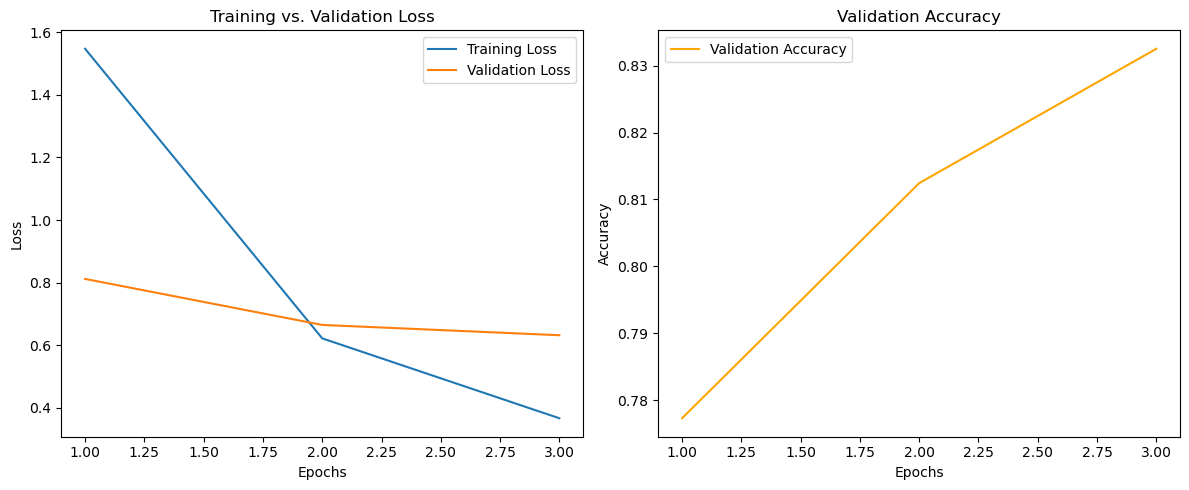

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.94      1.00      0.97        16
                      cereals and bakery products       0.79      0.83      0.81       121
     cocoa and cocoa preparations, coffee and tea       0.84      0.90      0.87        42
                                    confectionery       0.68      0.58      0.62        33
dietetic foods, food supplements, fortified foods       0.68      0.81      0.74        26
                                    fats and oils       1.00      0.83      0.91         6
                   food additives and flavourings       0.50      0.25      0.33         4
                            fruits and vegetables       0.88      0.83      0.85       103
                                 herbs and spices       0.62      0.75      0.68        20
                            honey and royal jelly       1.00      0.50      0.67         

In [ ]:
# ---------------------------
# Βήμα 5: Φόρτωση του μοντέλου για sequence classification
# ---------------------------
num_labels = len(label_encoder.classes_)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model = model.to(device)

# ---------------------------
# Βήμα 6: Εκπαίδευση του μοντέλου
# ---------------------------
# Χρησιμοποιούμε τη συνάρτηση train_and_evaluate_model που εκπαιδεύει το μοντέλο
model = train_and_evaluate_model_with_plot(model, train_loader, dev_loader, num_epochs=3, lr=2e-5)

# ---------------------------
# Βήμα 7: Αξιολόγηση του μοντέλου
# ---------------------------
# Χρησιμοποιούμε τη συνάρτηση generate_classification_report για να δούμε τα αποτελέσματα
generate_classification_report(model, dev_loader, device, label_encoder, dev_df, label)
# Περνάμε τα δεδομένα σε νέο πίνακα για να υπάρχουν αποθηκευμένα, το dev_df αρχικοποιείται πάλι
dev_df_product = dev_df

### Τελικό Macro F1 για το PRODUCT-CATEGORY :  0.78

## HAZARD - CATEGORY

Στο HAZARD - CATEGORY ακολουθήθηκε η ίδια διαδικασία με το PRODUCT - CATEGORY , χωρίς το DATA AUGMENTANTION καθώς η εφαρμογή του δεν επέφερε αποτελέσματα στο μοντέλο. Οι κλάσεις του είναι πιο ισορροπημένες.

In [ ]:
# Βήμα 1 : Ξεκινάμε την εκπαίδευση από την αρχή γιατί το hazard-category δεν χρειάζεται data augmentation
# ---------------------------
# Βήμα 2: Φόρτωση δεδομένων
# ---------------------------
# Υποθέτουμε ότι τα αρχεία CSV έχουν στήλες: 'title', 'text' και 'product-category'
train_file = 'incidents_train.csv'
test_file  = 'incidents_test.csv'
train_df, dev_df, data = load_data(train_file, test_file)

# ---------------------------
# Βήμα 3: Label Encoding για το 'hazard-category'
# ---------------------------
label = 'hazard-category'
label_encoder = LabelEncoder()
label_encoder.fit(data[label])
train_df['labels'] = label_encoder.transform(train_df[label])
dev_df['labels'] = label_encoder.transform(dev_df[label])

# ---------------------------
# Βήμα 4: Δημιουργία Hugging Face Datasets και tokenization
# ---------------------------
# Μετατροπή των pandas DataFrame σε Datasets
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)

# Εφαρμογή tokenization που συνδυάζει 'title' και 'text'
train_dataset = train_dataset.map(lambda examples: tokenize_title_and_text(examples, tokenizer), batched=True)
dev_dataset = dev_dataset.map(lambda examples: tokenize_title_and_text(examples, tokenizer), batched=True)

# Ορισμός DataCollator για αυτόματο padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Ορισμός του format των δεδομένων ως tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
dev_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Δημιουργία DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16, collate_fn=data_collator)
dev_loader   = DataLoader(dev_dataset, batch_size=16, collate_fn=data_collator)

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

  0%|          | 0/954 [00:00<?, ?it/s]

Epoch 1/3 - Training Loss: 0.6592
Epoch 1/3 - Validation Loss: 0.2528 - Accuracy: 0.9398
Epoch 2/3 - Training Loss: 0.1785
Epoch 2/3 - Validation Loss: 0.1993 - Accuracy: 0.9478
Epoch 3/3 - Training Loss: 0.1101
Epoch 3/3 - Validation Loss: 0.1800 - Accuracy: 0.9579


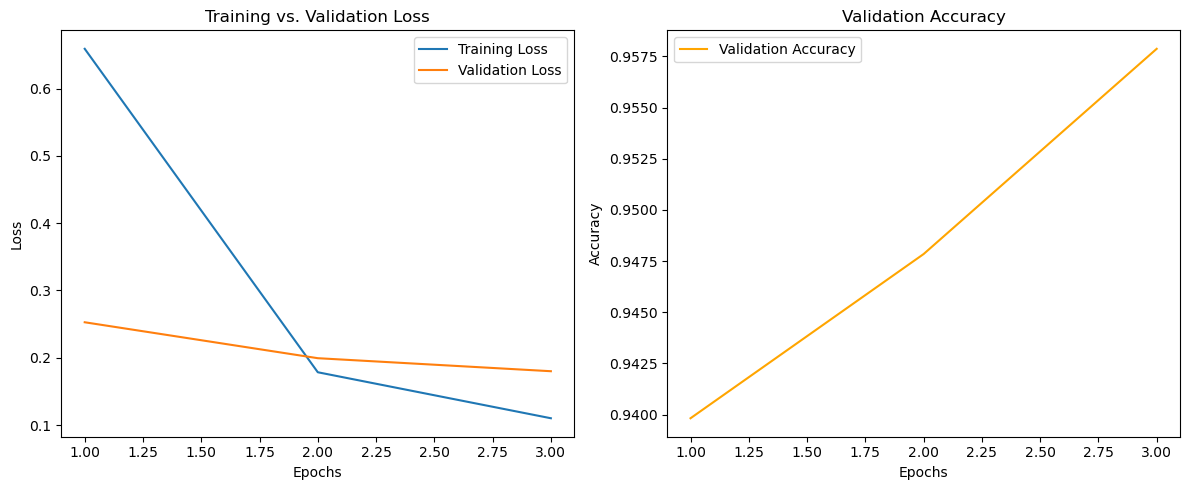

                                precision    recall  f1-score   support

                     allergens       0.97      0.98      0.97       365
                    biological       0.99      0.99      0.99       343
                      chemical       0.96      0.92      0.94        52
food additives and flavourings       1.00      0.50      0.67         4
                foreign bodies       0.96      0.99      0.98       111
                         fraud       0.85      0.81      0.83        75
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.91      1.00      0.95        10
                  other hazard       0.81      0.81      0.81        26
              packaging defect       0.82      0.90      0.86        10

                      accuracy                           0.96       997
                     macro avg       0.83      0.79      0.80       997
                  weighted avg       0.96      0.96      0.96 

In [ ]:
# ---------------------------
# Βήμα 5: Φόρτωση του μοντέλου για sequence classification
# ---------------------------
num_labels = len(label_encoder.classes_)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model = model.to(device)

# ---------------------------
# Βήμα 6: Εκπαίδευση του μοντέλου
# ---------------------------
# Χρησιμοποιούμε τη συνάρτηση train_and_evaluate_model που εκπαιδεύει το μοντέλο
model = train_and_evaluate_model_with_plot(model, train_loader, dev_loader, num_epochs=3, lr=2e-5)

# ---------------------------
# Βήμα 7: Αξιολόγηση του μοντέλου
# ---------------------------
# Χρησιμοποιούμε τη συνάρτηση generate_classification_report για να δούμε τα αποτελέσματα
generate_classification_report(model, dev_loader, device, label_encoder, dev_df, label)
dev_df_hazard = dev_df

### Τελικό Macro F1 για το HAZARD-CATEGORY :  0.80

In [ ]:
from sklearn.metrics import f1_score

def compute_score(hazards_true, products_true, hazards_pred, products_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )

  # compute f1 for products:
  f1_products = f1_score(
    products_true[hazards_pred == hazards_true],
    products_pred[hazards_pred == hazards_true],
    average='macro'
  )

  return (f1_hazards + f1_products) / 2.

## SCORE FOR SUB-TASK 1 :

In [ ]:
score = compute_score(
    dev_df_hazard['hazard-category'], dev_df_product['product-category'],
    dev_df_hazard['predictions-hazard-category'], dev_df_product['predictions-product-category']
)
print(f"Score Sub-Task 1: {score:.3f}")

Score Sub-Task 1: 0.790


### Τελικό SUB-TASK 1 SCORE :  0.79

------------------------------------
------------------------------------

# SUB-TASK 2

## HAZARD

Διαβάζουμε εκ νέου τα αρχεία, κάθε φορά που κατασκευάζουμε ένα μοντέλο. Δεν είναι σωστή πρακτική, απλώς βοηθάει στην εκσφαλμάτωση.

In [ ]:
# ---------------------------
# Βήμα 1: Φόρτωση δεδομένων
train_file = 'incidents_train.csv'
test_file  = 'incidents_test.csv'
train_df, dev_df, data = load_data(train_file, test_file)

DATA - AUGMENTATION : κατώφλι = 10, νέες γραμμές για κάθε σπάνια κατηγορία = 2

In [ ]:
#Βήμα 2 : Augmentation των training δεδομένων
import pandas as pd
import random

def random_word_removal(text, removal_prob=0.2):
    """ Τυχαία αφαίρεση λέξεων από ένα κείμενο. """
    words = text.split()
    new_words = [word for word in words if random.random() > removal_prob]
    return ' '.join(new_words) if new_words else text

def find_rare_classes(df, label_column, threshold=10):
    """
    Βρίσκει τις σπάνιες κλάσεις (με λιγότερα από `threshold` δείγματα).

    Args:
        df (pd.DataFrame): Το αρχικό DataFrame.
        label_column (str): Η στήλη με τις ετικέτες.
        threshold (int): Το κατώφλι κάτω από το οποίο θεωρείται μια κλάση σπάνια.

    Returns:
        List[str]: Λίστα με τις σπάνιες κλάσεις.
    """
    class_counts = df[label_column].value_counts()
    rare_classes = class_counts[class_counts < threshold].index.tolist()
    return rare_classes

def augment_dataframe_fixed(df, label_column, text_column, extra_samples_per_class=5, removal_prob=0.2):
    """
    Δημιουργεί 4 νέα παραλλαγές για κάθε σπάνια κλάση.

    Args:
        df (pd.DataFrame): Το αρχικό DataFrame.
        label_column (str): Η στήλη με τις ετικέτες.
        text_column (str): Η στήλη με το κείμενο που θα αλλάξει.
        extra_samples_per_class (int): Πόσα νέα δείγματα θα προστεθούν σε κάθε σπάνια κλάση.
        removal_prob (float): Πιθανότητα αφαίρεσης κάθε λέξης.

    Returns:
        pd.DataFrame: Το νέο DataFrame με τα augmented δεδομένα.
    """
    augmented_rows = []
    for rare_label in df[label_column].unique():
        rare_samples = df[df[label_column] == rare_label]
        for _ in range(extra_samples_per_class):
            sampled_row = rare_samples.sample(n=1, replace=True).iloc[0]  # Τυχαίο δείγμα από την ίδια κλάση
            aug_text = random_word_removal(sampled_row[text_column], removal_prob=removal_prob)
            new_row = sampled_row.copy()
            new_row[text_column] = aug_text
            new_row['augmented'] = True  # Προσθέτουμε flag για tracking
            augmented_rows.append(new_row)
    
    return pd.DataFrame(augmented_rows)

# ---------------------------
# 🎯 ΕΦΑΡΜΟΓΗ AUGMENTATION ΜΕ +4 ΔΕΙΓΜΑΤΑ ΣΕ ΚΑΘΕ ΣΠΑΝΙΑ ΚΛΑΣΗ
# ---------------------------

# ✅ 1. Εντοπισμός σπάνιων κλάσεων (κάτω από 10 δείγματα)
threshold = 10  # Σπάνιες θεωρούνται όσες έχουν < 10 δείγματα
rare_classes = find_rare_classes(train_df, label_column='hazard', threshold=threshold)

print(f"🔍 Βρέθηκαν {len(rare_classes)} σπάνιες κλάσεις.")

# ✅ 2. Φιλτράρουμε το DataFrame για τις σπάνιες κλάσεις
df_rare = train_df[train_df['hazard'].isin(rare_classes)]
df_common = train_df[~train_df['hazard'].isin(rare_classes)]

# ✅ 3. Εφαρμόζουμε augmentation μόνο στα σπάνια δεδομένα (+4 δείγματα ανά κλάση)
df_rare_augmented = augment_dataframe_fixed(df_rare, label_column='hazard', text_column='title', extra_samples_per_class=5, removal_prob=0.2)

# ✅ 4. Συνδυάζουμε το αρχικό dataset με τα augmented δεδομένα
train_df_augmented = pd.concat([df_common, df_rare, df_rare_augmented], ignore_index=True)

print(f"📊 Αρχικά δείγματα: {len(train_df)}, Μετά το augmentation: {len(train_df_augmented)}")

train_df = train_df_augmented

🔍 Βρέθηκαν 68 σπάνιες κλάσεις.
📊 Αρχικά δείγματα: 5082, Μετά το augmentation: 5422


DATA - AUGMENTATION : κατώφλι = 10, νέες γραμμές για κάθε σπάνια κατηγορία = 2

Focal Loss για Αντιμετώπιση Ανισορροπίας Κλάσεων

- `FocalLoss()`: Προσαρμοσμένη συνάρτηση απώλειας που μειώνει την επίδραση των εύκολων παραδειγμάτων, βελτιώνοντας την εκπαίδευση σε ανισόρροπα δεδομένα.


In [ ]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm

# ---------------------------
# Ορισμός Focal Loss ως custom loss function
# ---------------------------
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        """
        Args:
            alpha: Βάρος για τις κλάσεις.
            gamma: Ο παράγοντας που μειώνει την επίδραση των εύκολων παραδειγμάτων.
            reduction: 'mean', 'sum' ή 'none' για τον τρόπο συνάθροισης του loss.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: Raw logits από το μοντέλο (διαστάσεων [batch_size, num_classes]).
            targets: Οι αληθινές κλάσεις (διαστάσεων [batch_size]).
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

Εκπαίδευση του μοντέλου με Focal Loss

- `train_model_with_focal_loss_with_plot()`: Εκπαιδεύει το μοντέλο χρησιμοποιώντας **Focal Loss** για καλύτερη απόδοση σε ανισόρροπα δεδομένα.
- Υπολογίζει το **training loss**, το **validation loss** και την **accuracy** σε κάθε epoch.
- Προβάλλει γραφήματα για την παρακολούθηση πιθανής υπερπροσαρμογής (**overfitting**).


In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def train_model_with_focal_loss_with_plot(model, train_dataloader, dev_dataloader, num_epochs=4, lr=2e-5, device='cuda', alpha=0.5, gamma=3):
    """
    Εκπαιδεύει το μοντέλο χρησιμοποιώντας Focal Loss και παρακολουθεί την απόδοση στο validation set
    ώστε να εντοπιστεί πιθανό overfitting.
    
    Σε κάθε epoch, υπολογίζει το training loss, το validation loss και την ακρίβεια.
    Στο τέλος εμφανίζει γραφήματα για την εξέλιξη αυτών των μετρικών.
    
    Args:
        model: Το μοντέλο προς εκπαίδευση.
        train_dataloader: DataLoader για τα training δεδομένα.
        dev_dataloader: DataLoader για τα validation δεδομένα.
        num_epochs: Αριθμός epochs εκπαίδευσης.
        lr: Ρυθμός μάθησης.
        device: Η συσκευή ('cuda' ή 'cpu').
        alpha: Παράμετρος για το Focal Loss.
        gamma: Παράγοντας για το Focal Loss.
    
    Returns:
        Το εκπαιδευμένο μοντέλο.
    """
    if label == 'product' :
        num_epochs = 10
        alpha = 0.25
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = num_epochs * len(train_dataloader)
    warmup_steps = int(0.1 * num_training_steps)
    scheduler = get_scheduler("linear", optimizer=optimizer, 
                              num_warmup_steps=warmup_steps, 
                              num_training_steps=num_training_steps)
    
    scaler = GradScaler()
    focal_loss_fn = FocalLoss(alpha=alpha, gamma=gamma)
    progress_bar = tqdm(range(num_training_steps))
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        steps = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask']
                )
                logits = outputs.logits
                loss = focal_loss_fn(logits, batch['labels'])
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            
            epoch_train_loss += loss.item()
            steps += 1
            progress_bar.update(1)
        
        avg_train_loss = epoch_train_loss / steps
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Focal Loss (Training): {avg_train_loss:.4f}")
        
        # Αξιολόγηση στο validation set:
        val_loss, val_accuracy = evaluate_model(model, dev_dataloader, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f} - Accuracy: {val_accuracy:.4f}")
    
    # Plot των μετρικών για να παρακολουθήσουμε το overfitting
    epochs = range(1, num_epochs+1)
    plt.figure(figsize=(12, 5))
    
    # Plot Training vs Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    
    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model

Προετοιμασία δεδομένων όπως και νωρίτερα

In [ ]:
# ---------------------------
# Βήμα 3: Label Encoding για το 'hazard'
# ---------------------------
label = 'hazard'
label_encoder = LabelEncoder()
label_encoder.fit(data[label])
train_df['labels'] = label_encoder.transform(train_df[label])
dev_df['labels'] = label_encoder.transform(dev_df[label])

# ---------------------------
# Βήμα 4: Δημιουργία Hugging Face Datasets και tokenization
# ---------------------------
# Μετατροπή των pandas DataFrame σε Datasets
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)

# Εφαρμογή tokenization που συνδυάζει 'title' και 'text'
train_dataset = train_dataset.map(lambda examples: tokenize_title_and_text(examples, tokenizer), batched=True)
dev_dataset = dev_dataset.map(lambda examples: tokenize_title_and_text(examples, tokenizer), batched=True)

# Ορισμός DataCollator για αυτόματο padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Ορισμός του format των δεδομένων ως tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
dev_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Δημιουργία DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16, collate_fn=data_collator)
dev_loader   = DataLoader(dev_dataset, batch_size=16, collate_fn=data_collator)

Map:   0%|          | 0/5422 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Εκπαίδευση και αξιολόγηση του μοντέλου

In [ ]:
# ---------------------------
# Βήμα 5: Φόρτωση του μοντέλου για sequence classification
# ---------------------------
num_labels = len(label_encoder.classes_)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model = model.to(device)

# ---------------------------
# Βήμα 6: Εκπαίδευση του μοντέλου
# ---------------------------

# Χρησιμοποιούμε τη συνάρτηση train_and_evaluate_model που εκπαιδεύει το μοντέλο
model = train_model_with_focal_loss_with_plot(model, train_loader, dev_loader, num_epochs=4, lr=2e-5)
# ---------------------------
# Βήμα 7: Αξιολόγηση του μοντέλου
# ---------------------------
# Χρησιμοποιούμε τη συνάρτηση generate_classification_report για να δούμε τα αποτελέσματα
generate_classification_report(model, dev_loader, device, label_encoder, dev_df, label)
dev_df_hazard2 = dev_df

  0%|          | 0/1356 [00:00<?, ?it/s]

Epoch 1/4 - Focal Loss (Training): 1.1132
Epoch 1/4 - Validation Loss: 1.2054 - Accuracy: 0.7924


### Τελικό Macro F1 για το HAZARD :  0.78

## PRODUCT

In [ ]:
# ---------------------------
# Βήμα 1: Φόρτωση δεδομένων
train_file = 'incidents_train.csv'
test_file  = 'incidents_test.csv'
train_df, dev_df, data = load_data(train_file, test_file)

In [ ]:
# ---------------------------
# Βήμα 3: Label Encoding για το 'product'
# ---------------------------
label = 'product'
label_encoder = LabelEncoder()
label_encoder.fit(data[label])
train_df['labels'] = label_encoder.transform(train_df[label])
dev_df['labels'] = label_encoder.transform(dev_df[label])

# ---------------------------
# Βήμα 4: Δημιουργία Hugging Face Datasets και tokenization
# ---------------------------
# Μετατροπή των pandas DataFrame σε Datasets
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)

# Εφαρμογή tokenization που συνδυάζει 'title' και 'text'
train_dataset = train_dataset.map(lambda examples: tokenize_title_and_text(examples, tokenizer), batched=True)
dev_dataset = dev_dataset.map(lambda examples: tokenize_title_and_text(examples, tokenizer), batched=True)

# Ορισμός DataCollator για αυτόματο padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Ορισμός του format των δεδομένων ως tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
dev_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Δημιουργία DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16, collate_fn=data_collator)
dev_loader   = DataLoader(dev_dataset, batch_size=16, collate_fn=data_collator)

# ---------------------------
# Βήμα 5: Φόρτωση του μοντέλου για sequence classification
# ---------------------------
num_labels = len(label_encoder.classes_)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model = model.to(device)

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Τα epochs ορίστηκαν σε 10, γιατί λόγω του μεγάλου inbalancing το product καθυστερούσε να μάθει τισ μικρές κατηγορίες (Σε συνδυασμό με το Focal Loss που δινόταν βάση στις λιγότερο σημαντικές).

  0%|          | 0/3180 [00:00<?, ?it/s]

Epoch 1/10 - Focal Loss (Training): 1.6545
Epoch 1/10 - Validation Loss: 6.2652 - Accuracy: 0.0572
Epoch 2/10 - Focal Loss (Training): 1.3504
Epoch 2/10 - Validation Loss: 4.8142 - Accuracy: 0.3109
Epoch 3/10 - Focal Loss (Training): 1.0113
Epoch 3/10 - Validation Loss: 4.0885 - Accuracy: 0.4002
Epoch 4/10 - Focal Loss (Training): 0.8058
Epoch 4/10 - Validation Loss: 3.7563 - Accuracy: 0.4433
Epoch 5/10 - Focal Loss (Training): 0.6728
Epoch 5/10 - Validation Loss: 3.5148 - Accuracy: 0.4674
Epoch 6/10 - Focal Loss (Training): 0.5770
Epoch 6/10 - Validation Loss: 3.3286 - Accuracy: 0.5075
Epoch 7/10 - Focal Loss (Training): 0.5052
Epoch 7/10 - Validation Loss: 3.2427 - Accuracy: 0.5125
Epoch 8/10 - Focal Loss (Training): 0.4520
Epoch 8/10 - Validation Loss: 3.1694 - Accuracy: 0.5216
Epoch 9/10 - Focal Loss (Training): 0.4176
Epoch 9/10 - Validation Loss: 3.1318 - Accuracy: 0.5246
Epoch 10/10 - Focal Loss (Training): 0.3925
Epoch 10/10 - Validation Loss: 3.1225 - Accuracy: 0.5296


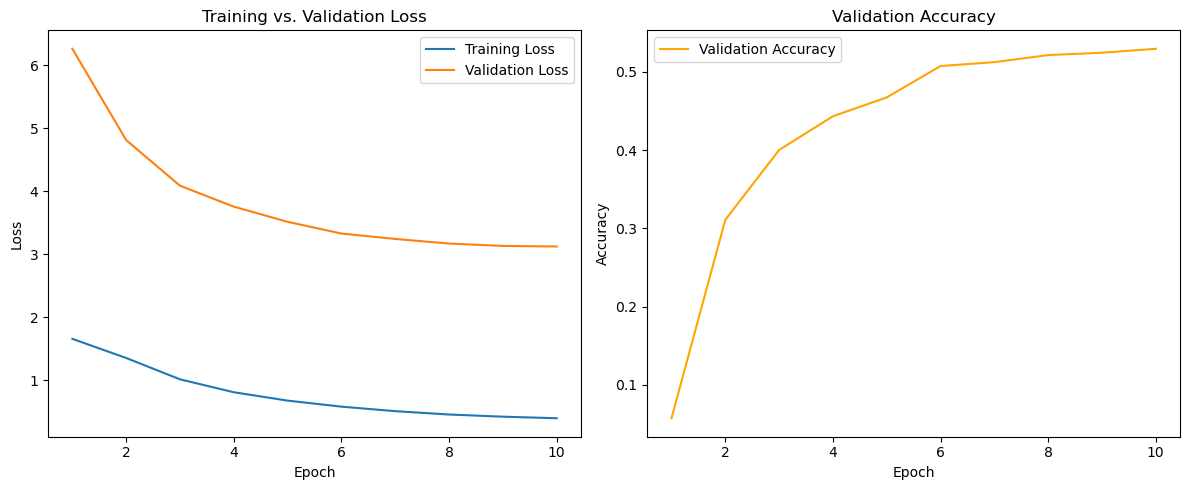

                                                               precision    recall  f1-score   support

                                       Catfishes (freshwater)       0.50      1.00      0.67         3
                                              Dried pork meat       0.00      0.00      0.00         1
                                        Fishes not identified       0.46      0.75      0.57         8
                                     Not classified pork meat       0.50      0.33      0.40         3
                          Precooked cooked pork meat products       0.00      0.00      0.00         1
                                            Saurida (generic)       0.00      0.00      0.00         1
                                                Veggie Burger       0.33      1.00      0.50         1
                                                        algae       1.00      1.00      1.00         1
                                               almond kernels       0.00

In [ ]:
# ---------------------------
# Βήμα 6: Εκπαίδευση του μοντέλου
# ---------------------------
# Χρησιμοποιούμε τη συνάρτηση train_and_evaluate_model που εκπαιδεύει το μοντέλο
model = train_model_with_focal_loss_with_plot(model, train_loader, dev_loader, num_epochs=10, lr=2e-5)

# ---------------------------
# Βήμα 7: Αξιολόγηση του μοντέλου
# ---------------------------
# Χρησιμοποιούμε τη συνάρτηση generate_classification_report για να δούμε τα αποτελέσματα
generate_classification_report(model, dev_loader, device, label_encoder, dev_df, label)
dev_df_products2 = dev_df

### Τελικό Macro F1 για το PRODUCT :  0.27

## SCORE FOR SUB-TASK 2 :

In [ ]:
score = compute_score(
    dev_df_hazard2['hazard'], dev_df_products2['product'],
    dev_df_hazard2['predictions-hazard'], dev_df_products2['predictions-product']
)
print(f"Score Sub-Task 2: {score:.3f}")

Score Sub-Task 2: 0.420


### Τελικό SUB-TASK 1 SCORE :  0.42

# ΤΕΛΙΚΟ ΑΡΧΕΙΟ

In [ ]:
dev_df_hazard.head()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product,labels,predictions-hazard-category
0,1994,10,20,us,Recall Notification: FSIS-039-94,Case Number: 039-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices,1,biological
1,1995,5,6,us,Recall Notification: FSIS-026-95,Case Number: 026-95 \n Date Opene...,biological,fruits and vegetables,listeria spp,broccoli,1,biological
2,1995,6,7,us,Recall Notification: FSIS-028-95,Case Number: 028-95 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,thermal processed pork meat,1,biological
3,1998,3,17,au,Black & Gold—Sliced Silverside 250g,PRA No. 1998/3500 Date published 17 Mar 1998 P...,biological,"meat, egg and dairy products",listeria monocytogenes,sliced ham,1,biological
4,1998,9,10,au,Nestle—Peters—Neapolitan Ice Cream,PRA No. 1998/3645 Date published 10 Sep 1998 P...,foreign bodies,ices and desserts,metal fragment,ice cream,4,foreign bodies


In [ ]:
dev_df_product.head()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product,labels,predictions-product-category
0,1994,10,20,us,Recall Notification: FSIS-039-94,Case Number: 039-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices,13,"meat, egg and dairy products"
1,1995,5,6,us,Recall Notification: FSIS-026-95,Case Number: 026-95 \n Date Opene...,biological,fruits and vegetables,listeria spp,broccoli,9,"meat, egg and dairy products"
2,1995,6,7,us,Recall Notification: FSIS-028-95,Case Number: 028-95 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,thermal processed pork meat,13,"meat, egg and dairy products"
3,1998,3,17,au,Black & Gold—Sliced Silverside 250g,PRA No. 1998/3500 Date published 17 Mar 1998 P...,biological,"meat, egg and dairy products",listeria monocytogenes,sliced ham,13,"meat, egg and dairy products"
4,1998,9,10,au,Nestle—Peters—Neapolitan Ice Cream,PRA No. 1998/3645 Date published 10 Sep 1998 P...,foreign bodies,ices and desserts,metal fragment,ice cream,12,ices and desserts


In [ ]:
dev_df_hazard2.head()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product,labels,predictions-hazard
0,1994,10,20,us,Recall Notification: FSIS-039-94,Case Number: 039-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices,55,listeria monocytogenes
1,1995,5,6,us,Recall Notification: FSIS-026-95,Case Number: 026-95 \n Date Opene...,biological,fruits and vegetables,listeria spp,broccoli,56,listeria monocytogenes
2,1995,6,7,us,Recall Notification: FSIS-028-95,Case Number: 028-95 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,thermal processed pork meat,55,listeria monocytogenes
3,1998,3,17,au,Black & Gold—Sliced Silverside 250g,PRA No. 1998/3500 Date published 17 Mar 1998 P...,biological,"meat, egg and dairy products",listeria monocytogenes,sliced ham,55,listeria monocytogenes
4,1998,9,10,au,Nestle—Peters—Neapolitan Ice Cream,PRA No. 1998/3645 Date published 10 Sep 1998 P...,foreign bodies,ices and desserts,metal fragment,ice cream,57,metal fragment


Συνδυασμός των predictions για κάθε label.

In [ ]:
# Δημιουργία του τελικού DataFrame συνδυάζοντας τις στήλες από τους πίνακες
final_df = pd.DataFrame({
    'predictions-hazard-category': dev_df_hazard['predictions-hazard-category'].values,
    'predictions-product-category': dev_df_product['predictions-product-category'].values,
    'predictions-hazard': dev_df_hazard2['predictions-hazard'].values,
    'predictions-product': dev_df_products2['predictions-product'].values
})

# Εμφάνιση των πρώτων γραμμών του DataFrame για έλεγχο
print(final_df.head())

  predictions-hazard-category  predictions-product-category  \
0                  biological  meat, egg and dairy products   
1                  biological  meat, egg and dairy products   
2                  biological  meat, egg and dairy products   
3                  biological  meat, egg and dairy products   
4              foreign bodies             ices and desserts   

       predictions-hazard predictions-product  
0  listeria monocytogenes         ground beef  
1  listeria monocytogenes             sausage  
2  listeria monocytogenes         ground beef  
3  listeria monocytogenes             sausage  
4          metal fragment           ice cream  


Τελικό αρχείο csv για τα predictions.

In [ ]:
# Αποθήκευση του τελικού DataFrame σε CSV
final_df.to_csv("final_predictions.csv", index=False)
